<a href="https://colab.research.google.com/github/gurmaaan/MedNN/blob/master/Trained_CNN_no_changes_in_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
%cd /gdrive/My\ Drive/MedNN

/gdrive/My Drive/MedNN


In [0]:
#pytorch
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models

# general
import os
from collections import defaultdict
import time
import json
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score

## Загрузка данных 

In [0]:
batch_size = 16
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
ims = 300
train_path = "img/train"
train_min_path = train_path + "_65"
train_enriched_path = train_path + "_enriched"

In [0]:
def get_transforms(resize = 300, center_crop = 300):
    tr_dict = {
        'train': 
        [
            transforms.Resize(resize),
            transforms.CenterCrop(center_crop),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ],
        'valid': 
        [
            transforms.Resize(resize),
            transforms.CenterCrop(center_crop),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ],
        'test': 
        [
            transforms.Resize(resize),
            transforms.CenterCrop(center_crop),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]
    }
    return tr_dict

In [0]:
data_transforms = get_transforms(256, 224)


In [0]:
paths = {
    "train" : train_path,
    "test" : "img/test",
    "valid" : "img/valid"
}

In [0]:
image_datasets = {x: ImageFolder(paths[x], transforms.Compose(data_transforms[x])) for x in paths}

In [0]:
class_names = image_datasets['train'].classes
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [0]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in paths}


In [0]:
# target = torch.tensor(image_datasets["train"].targets)
# class_sample_count = torch.tensor([(target == t).sum() for t in torch.unique(target, sorted=True)])
# weight = 1. / class_sample_count.float()
# samples_weight = torch.tensor([weight[t] for t in target])

# sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))
# dataloaders["train"] = DataLoader(image_datasets["train"], batch_size=batch_size, num_workers=4, sampler=sampler)

In [0]:
dataset_sizes = {x: len(image_datasets[x]) for x in paths}
dataset_sizes

{'test': 2504, 'train': 5633, 'valid': 1878}

In [0]:
class_counts = defaultdict(dict)
for p in paths:
    for cl in class_names:
        class_counts[p][cl] = len(os.listdir(f"{paths[p]}/{cl}"))
print(class_counts["train"])
print(class_counts["valid"])
print(class_counts["test"])

{'actinic keratosis': 71, 'basal cell carcinoma': 297, 'dermatofibroma': 65, 'melanoma': 608, 'nevus': 3760, 'pigmented benign keratosis': 632, 'squamous cell carcinoma': 120, 'vascular lesion': 80}
{'actinic keratosis': 29, 'basal cell carcinoma': 90, 'dermatofibroma': 22, 'melanoma': 202, 'nevus': 1272, 'pigmented benign keratosis': 208, 'squamous cell carcinoma': 30, 'vascular lesion': 25}
{'actinic keratosis': 30, 'basal cell carcinoma': 127, 'dermatofibroma': 28, 'melanoma': 303, 'nevus': 1673, 'pigmented benign keratosis': 259, 'squamous cell carcinoma': 47, 'vascular lesion': 37}


## Device

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))

Tesla T4


## Визуализация 

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    
    #revert normalization
    inp = std * inp + mean
    
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

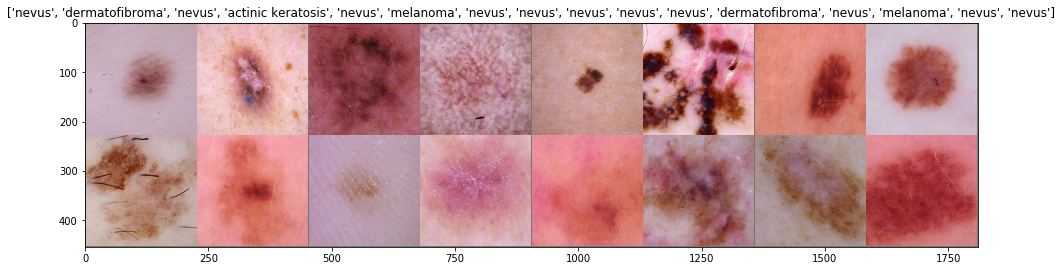

In [0]:
imgs, labels = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(imgs)

imshow(out, title=[class_names[x] for x in labels])

## Функции обучения


In [0]:
def train_model(model, criterion, optimizer, scheduler = None, num_epochs=25, print_log=True):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    stat_dict = {
        "train" :{
            "epoch" : [],
            "loss" : [],
            "acc" : []
        },
        "valid" :{
            "epoch" : [],
            "loss" : [],
            "acc" : []
        }
    }


    for epoch in range(num_epochs):
        print(f"Эпоха {epoch + 1}/{num_epochs}")
        print('-' * 10)

        # У каждой эпохи есть фаза обучения и фаза валидации 
        for phase in ["train", "valid"]:
            is_train_phase = (phase == "train")
            # Ставим модель в нужный режим в зависимости от фазы 
            model.train(is_train_phase)
            running_loss = 0.0
            running_corrects = 0
            
            # Проходим по датасету партиями размером с батч
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Обнуляем градиенты вычесленные на предыдущем батче, иначе они будут складываться один за другим 
                optimizer.zero_grad()
                # Прямой проход Общая для обучения и валидации. 
                # Если фаза обучения, то все градиенты (частные производные функции потерь) 
                # будут вычислены чтобы вычесть их из текущих весов. Если валидация - вычисляться не будут
                with torch.set_grad_enabled(is_train_phase):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Реализация обратного распространения ошибки 
                    if is_train_phase:
                        # Рассчет всех частных производных dloss_dw1(w1_0). Внутри батча усредняются
                        loss.backward()
                        # обновление весов (w1_1 = w1_0 - lr * dloss_dw1(w1_0) и так далее
                        optimizer.step() 

                # statistics inputs.size(0) = batch_size 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if is_train_phase and (scheduler is not None):
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            stat_dict[phase]["epoch"].append(epoch)
            stat_dict[phase]["loss"].append(epoch_loss)
            stat_dict[phase]["acc"].append(epoch_acc.item())
            
            if print_log:
                print(f"{phase} - loss: {epoch_loss : .4f}, acc: {epoch_acc : .4f}")
#                 print(f"Learning rate: {get_lr(optimizer)}")
                time_elapsed = time.time() - start_time
                print(f"Time passed {time_elapsed // 60 : .0f} m {time_elapsed % 60 : .0f} s")
                
            # deep copy the model
            if (not is_train_phase) and (epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed // 60 : .0f}m {time_elapsed % 60 : .0f}s")
    print(f"Best val Acc: {best_acc : .4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, stat_dict

## Функция тестирования

In [0]:
def test_model(model, print_log=True):
    result_dict = {
        "real" : [],
        "predicted" : []
    }

    with torch.no_grad():
        for images, labels in dataloaders["test"]:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
                result_dict["real"].append(class_names[labels[i]])
                result_dict["predicted"].append(class_names[predicted[i]])

    result_df = pd.DataFrame(result_dict)
    result_df["answer"] = result_df.apply(lambda x: int(x["real"] == x["predicted"]), axis=1)

    acc_dict = {}
    total_acc = accuracy_score(result_df["real"], result_df["predicted"]) * 100
    acc_dict["total"] = total_acc
    
    if print_log:
        print(f"Total accuracy: {total_acc : .2f}%")

    for img_class in result_df["real"].unique():
        class_df = result_df[result_df["real"] == img_class]
        class_acc = accuracy_score(class_df["real"], class_df["predicted"]) * 100
        acc_dict[img_class] = class_acc
        if print_log:
            print(f"\t{img_class} ({len(class_df)}) : {class_acc : .2f}%")
    
    return acc_dict

## Вспомогательные функции 

In [0]:
def convert_score_to_df(score_dict, save_dir, save_path = "C:/Users/Dima/YandexDisk/EDUCATION/_Deeplom/nn"):
    data = defaultdict(list)
    if len(score_dict.keys()) > 0:
        first = list(score_dict.keys())[0]
        for scope in score_dict[first]:
            data["scope"].append(scope)
            for model_name in score_dict:
                data[model_name].append(round(score_dict[model_name][scope],2))
        
        df = pd.DataFrame(data)
        df = df.set_index("scope")
        
        output_dir = f"{save_path}/{save_dir}"
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        df.to_csv(f"{output_dir}/models_score.csv", sep=';')
    else:
        df  = pd.DataFrame()
    return df

In [0]:
def save_to_json(loss_dict, save_dir, modelname, save_path = "C:/Users/Dima/YandexDisk/EDUCATION/_Deeplom/nn"):
    output_dir = f"{save_path}/{save_dir}"
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    with open(f"{output_dir}/{modelname}.json", 'w') as json_file:
        json.dump(loss_dict, json_file)

## Обучение

In [0]:
save_path = "/nn"
save_dir = "default"

In [0]:
model_dict = {
    #     "vgg16" : models.vgg16(pretrained=True),
    # "squeezenet" : models.squeezenet1_0(pretrained=True),
    # "densenet" : models.densenet161(pretrained=True),
    # "googlenet " : models.googlenet(pretrained=True),
    # "shufflenet" : models.shufflenet_v2_x1_0(pretrained=True),
    # "mobilenet" : models.mobilenet_v2(pretrained=True),
    # "resnext50_32x4d" : models.resnext50_32x4d(pretrained=True),
    # "wide_resnet50_2" : models.wide_resnet50_2(pretrained=True),
    # "mnasnet" : models.mnasnet1_0(pretrained=True),
    # "inception_v3" : models.inception_v3(pretrained=True),
    "resnet18" : models.resnet18(pretrained=True)
    # "alexnet" : models.alexnet(pretrained=True)
}

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.7MB/s]


In [0]:
score_dict = {}

for model_name in model_dict:
    print('_' * 10, model_name, '_' * 10)
    model = model_dict[model_name]
    
    
    if model_name == "inception_v3":
        # Инсепшн по дефолту возвращает вероятность помимо лейбла
        # Отключаем эту опцию 
        model.aux_logits=False
        data_transforms = get_transforms(resize=299, center_crop=299)
        
    # Меняем последний полносвязный слой на количество классов которые есть у меня 
    if model_name not in ["resnet18", "resnet50", "inception_v3", "densenet"]:
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, len(class_names))
    else:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(class_names))
    
    model = model.to(device)

    # Определяем функцию по которой будет считаться ошибка между предсказанным значением и реальным
    # class_weights = [ 1- class_counts['test'][class_name] / dataset_sizes['test'] for class_name in class_names ]
    # class_weights = torch.FloatTensor(class_weights).cuda()
    criterion = nn.CrossEntropyLoss()
    # Говорим какие именно параметры модель будеть оптимизировать градиентным спуском 
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # Скорость обновляется в процессе обучения: каждые step_size шагов он умножается на gamma
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#     
    model, stat_dict = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15, print_log=True)

    save_to_json(stat_dict, save_dir, model_name)
    coeff_path = f"{save_path}/{save_dir}/{model_name}.pth"
    torch.save(model.state_dict(), coeff_path)

    print()

    score_dict[model_name] = test_model(model)

    print('\n' * 2)

convert_score_to_df(score_dict, save_dir)

## Визуализация результатов обучения 

In [0]:
def plot_learning_curve(path):
    data = json.load(open(path, 'r'))
    
    epochs = data["train"]["epoch"]
    
    fig, axs = plt.subplots(2, figsize=(16,12))
    title = path.split('/')[-1].split('.')[0]
    fig.suptitle(title)
    
    train_clr, test_clr = "coral", "lightblue"
    
    axs[0].set_title("Loss")
    axs[0].plot(epochs, data["train"]["loss"], label="train")
    axs[0].plot(epochs, data["valid"]["loss"], label="test")
    axs[0].set_xlabel("Epochs")
    axs[0].legend(loc=1)
    axs[0].grid()
    axs[0].set_xlim(xmin=0, xmax=epochs[-1])
    axs[0].set_xticks([xt for xt in range(0, epochs[-1], 2)])
    
    axs[1].set_title("Accuracy")
    axs[1].plot(epochs, data["train"]["acc"], label="train")
    axs[1].plot(epochs, data["test"]["acc"], label="test")
    axs[1].legend(loc=1)
    axs[1].grid()
    axs[1].set_xlim(xmin=0,xmax=epochs[-1])
    axs[1].set_xlabel("Epochs")
    axs[1].set_xticks([xt for xt in range(0, epochs[-1], 2)])

In [0]:
# plot_learning_curve("nn/enriched_max/learning/resnet50.json")

## Предсказание

In [0]:
def predict(img_path=None, model_name="inception_v3", path="C:\\Users\\Dima\\YandexDisk\\EDUCATION\\_Deeplom\\nn\\default\\coeffs\\inception_v3.pth"):
    img = Image.open(img_path)
    
    model = model_dict[model_name]
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 8)
    model.load_state_dict(torch.load(path))
    model.eval()
    
    img_input = transforms.Compose(data_transforms["test"])(img)
    img_input = img_input.unsqueeze(0)
    with torch.no_grad():
        output = model(img_input)
        _, predicted = torch.max(output.data, 1)
        proba = torch.nn.functional.softmax(output, dim=1).tolist()[0]
        
        plt.barh(class_names, proba, align="center")
        plt.xlim(0, 1)
        plt.xticks(np.arange(0, 1, 0.1))
        plt.grid(True, axis="x")
        
        for i, p in enumerate(proba):
            print(f"{p : .10f} - {class_names[i]}")
            plt.text(p, i, f"{p : .10f}")

In [0]:
# predict("img/carcinoma.jpg")